這邊我會假設你已經看過所有YOLOv3的系列文章，並且也瞭解前面幾個部份的說明

這邊主要是嚐試引入官方訓練好的權重。文章主要參考[The beginner’s guide to implementing YOLOv3 in TensorFlow 2.0 (part-3)](https://machinelearningspace.com/yolov3-tensorflow-2-part-3/)以及[machinelearningmastery](https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/)。

這次的參考來源的作法是利用yolov3的cfg檔來生成模型以及一連串的處理，蠻值得一看。

我的docker上執行的版本為tensorflow 2.1，雖然現在流行人生苦短我用PyTorch，不過我還是先繼續tf + keras。

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

指定使用的gpu

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

這邊就要先導入yolov3的模型，然後再載入相關權重，這當然跟你的input shape會有關係，所以記得下載的權重要注意一下版本，相關權重可以在https://pjreddie.com/darknet/yolo/ 下載。

首先載入需求套件

相關程式都可以再回頭看其它章節的說明，自己整理一個文件檔就可以了

In [4]:
from yolo_utility import yolov3, decoder

定義input shape，output，然後載入模型，值得注意的是，我最終實作的資料集是在VOC，而官方是COCO，所以維度會有所不同。

In [5]:
input_tensor = tf.keras.layers.Input([416, 416, 3])

In [6]:
yolov3_outputs = yolov3(input_tensor)
yolov3_outputs

(<tf.Tensor 'block_106_conv_1/Identity:0' shape=(None, 52, 52, 255) dtype=float32>,
 <tf.Tensor 'block_94_conv_1/Identity:0' shape=(None, 26, 26, 255) dtype=float32>,
 <tf.Tensor 'block_82_conv_1/Identity:0' shape=(None, 13, 13, 255) dtype=float32>)

In [7]:
decoder_output_tensors = []
for i, yolov3_output in enumerate(yolov3_outputs):    
    decoder_tensor = decoder(yolov3_output, 80, i)    
    decoder_output_tensors.append(decoder_tensor)
    
decoder_output_tensors    

[<tf.Tensor 'concat_2:0' shape=(None, None, None, 3, 85) dtype=float32>,
 <tf.Tensor 'concat_5:0' shape=(None, None, None, 3, 85) dtype=float32>,
 <tf.Tensor 'concat_8:0' shape=(None, None, None, 3, 85) dtype=float32>]

In [8]:
model = tf.keras.Model(input_tensor, decoder_output_tensors)

當然，下載下來的yolov3.weights並不是for keras model直接使用的，我們必需再做一些解析的動作。

In [9]:
model.load_weights("./model/yolov3.weights")

OSError: Unable to open file (file signature not found)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
block_1_conv_1 (Conv2D)         (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block_1_bn_2 (BatchNormalizatio (None, 416, 416, 32) 128         block_1_conv_1[0][0]             
__________________________________________________________________________________________________
block_1_leaky_3 (LeakyReLU)     (None, 416, 416, 32) 0           block_1_bn_2[0][0]               
______________________________________________________________________________________________

如果你有看過上面連結的內文就會發現，這個`yolov3.weights`裡面保存的就是浮點數值，就這樣，沒有其它的東西。也因此，如果我們要把這一堆的浮點數放回去模型，就必需要透過官方文件的cfg檔來處理。所以，讓我們先嚐試來處理一下cfg檔。

In [11]:
def parser_cfg(cfgpath: str):    
    with open(cfgpath, 'r') as file:
        lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
    i = 0
    holder = {}
    blocks = []    
    for line in lines:                
        if line[0] == '[':
            # 這邊單純的處理中括號
            # 代表的是一個block
            line = 'type=' + line[1:-1].rstrip()            
            if len(holder) != 0:    
                # 這我自己加的，為了能夠成功吃進大神訓練的權重，整個架構的命名我都改了
                holder['key_index'] = f'block_{str(i)}'
                i += 1
                blocks.append(holder)
                holder = {}
        key, value = line.split("=")        
        holder[key.rstrip()] = value.lstrip()
        

    blocks.append(holder)
    
    return blocks

In [12]:
cfgpath = './yolov3.cfg'
cfg = parser_cfg(cfgpath)

下面可以看的出來，剛剛利用函數`parser_cfg`處理官方的參數檔之後，我們已經順利的解析成python格式，每一個block的設置都一清二楚。

In [13]:
cfg[0: 3]

[{'type': 'net',
  'batch': '64',
  'subdivisions': '16',
  'width': '608',
  'height': '608',
  'channels': '3',
  'momentum': '0.9',
  'decay': '0.0005',
  'angle': '0',
  'saturation': '1.5',
  'exposure': '1.5',
  'hue': '.1',
  'learning_rate': '0.001',
  'burn_in': '1000',
  'max_batches': '500200',
  'policy': 'steps',
  'steps': '400000,450000',
  'scales': '.1,.1',
  'key_index': 'block_0'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '32',
  'size': '3',
  'stride': '1',
  'pad': '1',
  'activation': 'leaky',
  'key_index': 'block_1'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '64',
  'size': '3',
  'stride': '2',
  'pad': '1',
  'activation': 'leaky',
  'key_index': 'block_2'}]

In [14]:
len(cfg)

108

雖然是脫褲子放屁，不過如果你想用json來保存資料的話也可以這麼做....

In [15]:
import json

In [16]:
with open('cfg.json', 'w') as file:
    json.dump(cfg, file)

現在我們就要利用這個參數檔來做權重的解析，如果你有時間的話，真的應該看一下參考來源的做法，他是直接利用參數檔來生成模型架構。好處當然就是說，你只要下載官方的參數檔，就可以直接解析成相對應的模型，作法上非常優雅。等我們自己順過一次模型的流程，再來學學其他人的作法也不遲。

現在，我們就要拿著這個解析後的參數檔來做後續的處理。

先外部測試抓取資料

In [17]:
import numpy as np 

利用count控制一次取10個權重資料

In [18]:
fp = open('./model/yolov3.weights', 'rb')
print(np.fromfile(fp, dtype=np.float32, count=10))
fp.close()

[ 0.0000000e+00  2.8025969e-45  0.0000000e+00  8.5401272e-38
  0.0000000e+00 -4.3168850e+00 -7.5780761e-01 -2.1098018e+00
  1.7402638e+00  1.4071269e+00]


In [19]:
fp = open('./model/yolov3.weights', 'rb')
print(len(np.fromfile(fp, dtype=np.float32)))
fp.close()

62001762


有借有還記得close。這樣你就知道了，裡面放的就是權重值，沒了，所以我們一定要利用參數檔來做對應解析。

因為我的模型並不是跟參考來源的作者一樣是利用cfg檔來生成，而是有自己的命名原則，所以這部份就可能要痛苦一點的客製處理，總之就是注意，我們是以cfg的block做為解析的依據。

這邊要稍微注意的是，我的訓練模型是VOC的資料集，所以YOLO最終的output的filter是78，而這邊要採用的是COCO，所以最終的output的filter應該要是255，如果沒有注意到的話會造成這邊載入權重一直報錯。

In [20]:
def load_weights_v1(model, cfg, weight_path):
    # 開啟權重檔案
    fp = open(weight_path, "rb")
    # 前五個pass掉，其它的就是權重了
    np.fromfile(fp, dtype=np.int32, count=5)    
#     blocks = parse_cfg(cfgfile)
    for block in cfg:         
        if (block["type"] == "convolutional"):
            # 這就是我們剛剛解析文件過程中加進去的一個鍵值
            layer_name_prefix = block['key_index']
            conv_layer_name = layer_name_prefix + '_conv_1'
            conv_layer = model.get_layer(conv_layer_name)
            print(f'{conv_layer_name}: {conv_layer}')

            # 取得卷積層的資訊
            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]
            
            # 判斷是否有使用batch norm
            if "batch_normalize" in block:
                # 取得BN layer
                bn_layer_name = layer_name_prefix + '_bn_2'
                norm_layer = model.get_layer(bn_layer_name)
                print(f'{bn_layer_name}: {norm_layer} ')   
                
                # 取得BN layer的資訊，計算權重數
                size = np.prod(norm_layer.get_weights()[0].shape)
                # 取得權重值
                bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
                # BN layer有gamma、beta、mean、variance，所以我們要reshape
                # 然後取到的順序是beta、gamma、mean、variance，所以要再排序一下
                # tf [gamma, beta, mean, variance]                
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            else:
                # 沒有BN layer就單純的取得filter數量的對應權重數量
                conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)
            
            # 取得conv layer的權重值，相對應維度如下
            # darknet shape (out_dim, in_dim, height, width)
            # np.product就是把維度算一算看需要取幾個權重出來
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(
                fp, dtype=np.float32, count=np.product(conv_shape))
#             import pdb;pdb.set_trace()
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])
            if "batch_normalize" in block:
               
                norm_layer.set_weights(bn_weights)
                conv_layer.set_weights([conv_weights])
            else:
                conv_layer.set_weights([conv_weights, conv_bias])
    assert len(fp.read()) == 0, 'failed to read all data'
    fp.close()

In [21]:
weight_path = r'./model/yolov3.weights'
load_weights_v1(model, cfg, weight_path)

block_1_conv_1: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f21d2b805f8>
block_1_bn_2: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f21d2b63cc0> 
block_2_conv_1: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f21d0046668>
block_2_bn_2: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f21d0046da0> 
block_3_conv_1: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f21d00521d0>
block_3_bn_2: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f21d0076e10> 
block_4_conv_1: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f21d007f860>
block_4_bn_2: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f21d002b748> 
block_6_conv_1: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f219c1a7b38>
block_6_bn_2: <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object 

如果有需要的話，我們當然是可以直接去把這個權重檔另存成keras可以直接載入的格式，看個人需求。

現在，我們就用大神訓練的權重來測試看看我們在predict這篇文章中所做的方法是否正確

In [22]:
import os
from yolo_utility import get_training_data, plot_dataset, generate_data_for_loss
import matplotlib.patches as patches
import matplotlib.pyplot as plt

%matplotlib inline

這邊載入測試照片，其實我有點忘了我這邊張照片是那邊拿來的，後面有看到我再回來補引用來源

In [27]:
from PIL import Image
print(Image.__file__)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py


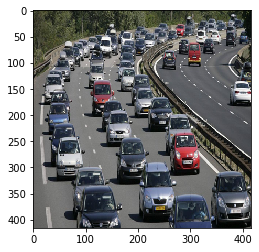

In [28]:
ipath = 'test-1.jpg'
ii = Image.open(ipath)
ii = ii.resize(size=(416, 416))
pix = np.array(ii)
pix = pix[np.newaxis, :]
plt.imshow(pix[0])

取得模型的輸出

In [29]:
model_output = model(pix.astype(np.float32) / 255.0)
model_output[0].shape, model_output[1].shape, model_output[2].shape

(TensorShape([1, 52, 52, 3, 85]),
 TensorShape([1, 26, 26, 3, 85]),
 TensorShape([1, 13, 13, 3, 85]))

我們的模型輸出根據之前的定義就是raw、decoder的組合，這個decoder之後的結果就是跟我們說，這52x52、26x26、13x13的grid cell的裡面的3個anchor box各有什麼資料，我們沒有那個美國時間慢慢處理三個尺度的資訊，最好的辦法就是跟菲姐一樣，通通喇在一起。

In [30]:
all_anchors = [tf.reshape(x, (-1, tf.shape(x)[-1])) for i, x in enumerate(model_output)]

In [31]:
all_anchors

[<tf.Tensor: shape=(8112, 85), dtype=float32, numpy=
 array([[3.9313941e+00, 2.1585298e+00, 6.8614964e+00, ..., 4.5345300e-03,
         2.8242425e-03, 1.4804679e-03],
        [3.9465649e+00, 4.0911207e+00, 7.9608216e+00, ..., 9.2205890e-03,
         9.9999104e-03, 4.3076938e-03],
        [4.0443654e+00, 2.8546240e+00, 8.3833870e+01, ..., 6.9717006e-03,
         8.0057960e-03, 6.5811276e-03],
        ...,
        [4.1136057e+02, 4.1184528e+02, 8.0199919e+00, ..., 3.6873514e-04,
         2.0759192e-04, 9.1886497e-05],
        [4.1127844e+02, 4.1042017e+02, 9.9567175e+00, ..., 1.0227994e-03,
         1.0733984e-03, 3.6290512e-04],
        [4.1074741e+02, 4.1168600e+02, 5.0286232e+01, ..., 7.4792281e-04,
         9.4660663e-04, 6.4677536e-04]], dtype=float32)>,
 <tf.Tensor: shape=(2028, 85), dtype=float32, numpy=
 array([[7.68199682e+00, 8.28668118e+00, 2.12998714e+01, ...,
         1.67847821e-03, 1.24015845e-03, 2.48229201e-03],
        [4.37656736e+00, 6.51403093e+00, 1.46939224e+02, ..

然後再把上面的list弄成一個很大的np array，從維度不難知道，一張照片產生10647個框來檢核。處理之前我們會先將資料格式轉成numpy。

In [32]:
import numpy as np

In [63]:
all_anchors = tf.concat(all_anchors, axis=0)
all_anchors.shape

TensorShape([10647, 85])

從這一陀框中取得需求的資訊，各別為位置資訊、置信度、類別機率

In [64]:
all_anchors = np.array(all_anchors)

anchors_xywh = all_anchors[:, 0: 4]
anchors_conf = all_anchors[:, 4]
anchors_prob = all_anchors[:, 5:]

anchors_xywh.shape, anchors_conf.shape, anchors_prob.shape

((10647, 4), (10647,), (10647, 80))

先將xywh轉成兩點座標，這邊我有一些細節沒有考慮到的就是，我是以input shape，也就是416x416來處理，所以我就沒有再做縮放，但你實際的input shape可能不會是416x416，那就需要記得再做個縮放。

In [65]:
anchors_lxlyrxry = np.concatenate([anchors_xywh[:, :2] - anchors_xywh[:, 2:] * 0.5,
                                   anchors_xywh[:, :2] + anchors_xywh[:, 2:] * 0.5], axis=-1)
anchors_lxlyrxry.shape

(10647, 4)

有些座標是超過範圍的，我們的範圍應該就是0~416，所以這邊要做特別的處理

In [66]:
anchors_lxlyrxry = np.concatenate([np.maximum(anchors_lxlyrxry[:, :2], [0, 0]),
                                   np.minimum(anchors_lxlyrxry[:, 2:], [416 - 1, 416 - 1])], axis=-1)

anchors_lxlyrxry[0]

array([0.50064588, 0.03668785, 7.36214256, 4.28037167])

另外就是，我們的座標是左上x、左上y、右下x、右下y，這意味著，左上x一定小於右下x，左上y一定小於右下y。如果有發生相反的情況，那這個預測本身是無效的。

In [67]:
fail_mask = np.logical_or((anchors_lxlyrxry[:, 0] > anchors_lxlyrxry[:, 2]), (anchors_lxlyrxry[:, 1] > anchors_lxlyrxry[:, 3]))
anchors_lxlyrxry[fail_mask] = 0

接下來就是利用面積開根號做一個排除，相關說明可見最後的附錄

In [68]:
valid_scale = [0, np.inf]

In [69]:
bboxes_scale = np.sqrt(np.multiply.reduce(anchors_lxlyrxry[:, 2:4] - anchors_lxlyrxry[:, 0:2], axis=-1))
scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

In [70]:
np.where(scale_mask==False, 1, 0).sum()

1

最後要排除掉置信度低於閥值的框

In [71]:
# 取得類別機率最高的類別索引
classes = np.argmax(anchors_prob, axis=-1)
classes.shape

(10647,)

In [72]:
np.unique(classes)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 13, 14, 17, 19, 25, 26,
       32, 34, 36, 37, 39, 41, 49, 50, 56, 58, 60])

取得每一個box機率最高那個類別索引的機率值

In [73]:
anchors_prob[np.arange(len(anchors_lxlyrxry)), classes]

array([0.20010892, 0.56011134, 0.22075178, ..., 0.5878771 , 0.59001577,
       0.684578  ], dtype=float32)

In [74]:
anchors_prob[np.arange(len(anchors_lxlyrxry)), classes].shape

(10647,)

然後把機率值跟置信度相乘

In [75]:
scores = anchors_conf * anchors_prob[np.arange(len(anchors_lxlyrxry)), classes]
scores.shape

(10647,)

設置閥值

In [76]:
score_mask = scores > 0.5
np.where(score_mask==True, 1, 0).sum()

123

把這個遮罩跟上面的遮罩做個and

In [77]:
mask = np.logical_and(scale_mask, score_mask)
np.where(mask==True, 1, 0).sum()

123

最後就得到了最終結果

In [78]:
lxlyrxry, scores, classes = anchors_lxlyrxry[mask], scores[mask], classes[mask]
lxlyrxry.shape, scores.shape, classes.shape

((123, 4), (123,), (123,))

把這三個陣列堆起來，不難明白後面兩個要推一個軸出去

In [79]:
final_result = np.concatenate([lxlyrxry, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)
final_result.shape

(123, 6)

In [80]:
final_result[:, 5]

array([2., 2., 2., 2., 7., 7., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 0., 0., 0., 7., 2., 2., 7., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2.])

整個過程可以發現到我一直在注意維度，因為維度真的很重要，一定要確定好。

先畫出一個還沒有執行iou的結果

x= 331.1885681152344, y= 15.119635581970215, w= 17.28192138671875, h= 23.717740058898926, label= 2.0
x= 348.675537109375, y= 19.5870361328125, w= 19.2464599609375, h= 19.83489990234375, label= 2.0
x= 272.1183166503906, y= 26.449737548828125, w= 17.92218017578125, h= 23.314971923828125, label= 2.0
x= 256.4981689453125, y= 37.709510803222656, w= 18.86004638671875, h= 18.1982421875, label= 2.0
x= 168.55343627929688, y= 40.41513442993164, w= 21.624847412109375, h= 28.28609848022461, label= 7.0
x= 166.2513885498047, y= 39.23215866088867, w= 26.35791015625, h= 30.203014373779297, label= 7.0
x= 309.93292236328125, y= 38.54095458984375, w= 22.10418701171875, h= 25.859695434570312, label= 2.0
x= 310.44775390625, y= 39.24579620361328, w= 23.9263916015625, h= 24.232643127441406, label= 2.0
x= 338.43243408203125, y= 39.332366943359375, w= 20.71478271484375, h= 26.28199005126953, label= 2.0
x= 335.6918640136719, y= 39.565834045410156, w= 24.685302734375, h= 25.420150756835938, label= 2.0
x= 367.190

<Figure size 1152x648 with 0 Axes>

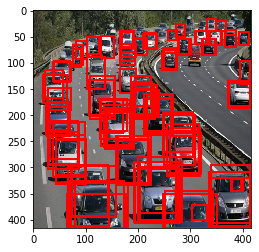

In [81]:
fig = plt.figure(figsize=(16, 9))
f, ax = plt.subplots(1, 1)
ax.imshow(pix[0])
# 一張照片上可能有多個物件，因此要迴圈處理    
for idx in range(final_result.shape[0]):
    obj = final_result[idx]
    
    _x = obj[0]
    _y = obj[1]
    _w = (obj[2]) - (obj[0])
    _h = (obj[3]) - (obj[1])


    # 畫方框
    rect = patches.Rectangle((_x, _y), 
                             _w, 
                             _h, 
                             linewidth=2, 
                             facecolor='none', 
                             edgecolor='red')                
    ax.add_patch(rect)
#     ax.text(x=_x, y=_y, color='red')    
    print(f'x= {_x}, y= {_y}, w= {_w}, h= {_h}, label= {obj[5]}')        

plt.show()

我們可以發現，有不少框都是在重覆區域，每個人都說波多是他的女友，但其實只是他們在夢遊，我們必需排除這種問題，這時候採用的作法就是[Non-max suppression](https://hackmd.io/@shaoeChen/HJUZTKMZz/https%3A%2F%2Fhackmd.io%2Fs%2FSJXmp66KG#3-7Non-max-suppression)。

上面連結的是吳恩達老師課程上的說明，所以很明顯的，不同類別的物件會各自去實現NMS

因為過程中會計算到iou，所以我們先弄個簡單函數

In [94]:
def xywh_to_lxlyrxry(boxes1, boxes2):
    """將bounding box中的xywh轉為左上、右下座標
    
    boxes的維度為batch_size x anchor_size x anchor_size x anchor_nums x xywh 
        其中anchor_size指的為yolo的不同尺度的output shape，如13x13、26x26、52x52
    """
    # 首先計算出兩個框的左上、右下點座標    
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)
    # 這邊的boxes已經是左上xy、右下xy的座標
    # 座標取小、取大，目前還不確定為什麼還要做一次這樣的動作
    # 理解上，左上座標一定是比右下座標來的小，反之亦然    
    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)
    
    return boxes1, boxes2

In [95]:
def get_iou(boxes1, boxes2):
    """計算兩個box的IoU
    
    boxes1, boxes2: batch_size x anchor_size x anchor_size x anchor_nums x xywh    
        xy: 中心座標
        wh: 寬高        
    """
    boxes1, boxes2 = xywh_to_lxlyrxry(boxes1, boxes2)
    # 各自計算面積，四個元素所代表的為：lx, ly, rx, ry
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])
    
    # 準備做交集面積的計算
    # 交集面積點座標，左上取大、右下取小    
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])
    
    # 計算交集面積的長寬
    inter_section = tf.maximum(right_down - left_up, 0.0)
    # 計算交集面積
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    # 計算聯集面積
    union_area = boxes1_area + boxes2_area - inter_area
    
    iou = 1.0 * inter_area / union_area
    # 回傳IoU
    return iou

首先我們確認類別數，這可以利用set的特性來做重覆值的排除

In [96]:
# 分解動作：取得所有照片內的所有類別
classes_in_img = list(set(final_result[:, 5]))
classes_in_img

[0.0, 2.0, 7.0]

In [97]:
best_bboxes = []
i = 0
for cls in classes_in_img:    
    # 做一個遮罩，多個類別，我們依各類別來處理
    cls_mask = (final_result[:, 5] ==  cls)    
    # 遮罩蓋上去就是剩下是那個類別的資料
    cls_bboxes = final_result[cls_mask]    
    while len(cls_bboxes) > 0:
        i += 1
        # 先取得機率最高的那一個類別的索引
        max_prob_ind = np.argmax(cls_bboxes[:, 4])        
        # 利用索引取得資料
        best_bbox = cls_bboxes[max_prob_ind]
        # 寫入
        best_bboxes.append(best_bbox)
        # 因為最佳的已經取出了，所以利用堆疊的方式把它排除
        # 上面為例，這時候的cls_bboxes就剩三筆資料
        cls_bboxes = np.concatenate([cls_bboxes[: max_prob_ind], cls_bboxes[max_prob_ind + 1:]])
        # 然後我們就計算這筆最佳的跟其它剩下的框之間的iou
        iou = get_iou(best_bbox[np.newaxis, : 4], cls_bboxes[:, : 4])
#         print(f'iou: {iou}')
        # 設置權重
        weight = np.ones((len(iou), ), dtype=np.float32)
        # 做一個遮罩，0.2的部份是一個閥值，可以以參數設置
        # 這麼做的用意在於說，我們已經先拿一個最高機率的框出來了
        # 跟這個機率最高的框還有iou的話，你肯定是有毛的
        # 所以，只要你們之間的iou太高，那就代表你們兩個有一定的機率是框到同一個東西
        # 跟我鬥，你洗洗睡，所以只要高過閥值的那個就歸零，自然就排除掉兩個框到同一個的問題
        iou_mask = (iou > 0.5).numpy()
        # 超過閥值的權重就歸零
        weight[iou_mask] = 0.0
        # 權重再乘上原始的置信度
        cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
        # 權重大於0的遮罩
        score_mask = cls_bboxes[:, 4] > 0.
        cls_bboxes = cls_bboxes[score_mask]
        
       

In [98]:
best_bboxes

[array([379.69656372, 323.07537842, 397.95120239, 344.76696777,
          0.77853453,   0.        ]),
 array([217.48310852, 168.27554321, 265.99212646, 231.99755859,
          0.99873567,   2.        ]),
 array([157.32766724, 246.93209839, 220.42355347, 331.08187866,
          0.99699974,   2.        ]),
 array([ 42.38684082, 238.74542236,  99.39318848, 329.39202881,
          0.99476147,   2.        ]),
 array([ 68.19487762, 326.40142822, 172.93249512, 415.        ,
          0.99444854,   2.        ]),
 array([340.3081665 , 308.76156616, 414.19494629, 412.11947632,
          0.99040133,   2.        ]),
 array([260.78082275, 234.2520752 , 319.62689209, 312.74481201,
          0.98628652,   2.        ]),
 array([322.82235718,  53.95863342, 347.99179077,  84.8677063 ,
          0.98528486,   2.        ]),
 array([374.26229858, 134.02287292, 415.        , 183.19425964,
          0.97628915,   2.        ]),
 array([247.59672546,  75.67759705, 274.37908936, 111.78819275,
          0.974787

x= 379.6965637207031, y= 323.07537841796875, w= 18.254638671875, h= 21.69158935546875
x= 217.4831085205078, y= 168.27554321289062, w= 48.50901794433594, h= 63.722015380859375
x= 157.32766723632812, y= 246.93209838867188, w= 63.09588623046875, h= 84.1497802734375
x= 42.3868408203125, y= 238.74542236328125, w= 57.00634765625, h= 90.6466064453125
x= 68.19487762451172, y= 326.40142822265625, w= 104.73761749267578, h= 88.59857177734375
x= 340.30816650390625, y= 308.7615661621094, w= 73.88677978515625, h= 103.35791015625
x= 260.78082275390625, y= 234.2520751953125, w= 58.8460693359375, h= 78.49273681640625
x= 322.8223571777344, y= 53.95863342285156, w= 25.16943359375, h= 30.909072875976562
x= 374.2622985839844, y= 134.0228729248047, w= 40.737701416015625, h= 49.17138671875
x= 247.5967254638672, y= 75.67759704589844, w= 26.782363891601562, h= 36.110595703125
x= 23.57191276550293, y= 177.29505920410156, w= 45.56112861633301, h= 51.444488525390625
x= 128.72622680664062, y= 169.24974060058594, w

<Figure size 1152x648 with 0 Axes>

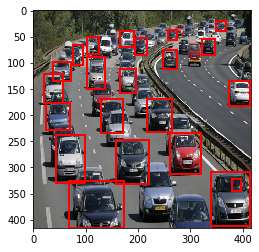

In [99]:
fig = plt.figure(figsize=(16, 9))
f, ax = plt.subplots(1, 1)
ax.imshow(pix[0])
# 一張照片上可能有多個物件，因此要迴圈處理    
for idx in range(len(best_bboxes)):
    obj = best_bboxes[idx]
    
    _x = obj[0]
    _y = obj[1]
    _w = (obj[2]) - (obj[0])
    _h = (obj[3]) - (obj[1])


    # 畫方框
    rect = patches.Rectangle((_x, _y), 
                             _w, 
                             _h, 
                             linewidth=2, 
                             facecolor='none', 
                             edgecolor='red')                
    ax.add_patch(rect)
#     ax.text(x=_x, y=_y, color='red')    
    print(f'x= {_x}, y= {_y}, w= {_w}, h= {_h}')        

plt.show()

也許透過調整閥值可以得到不一樣的結果，不過這邊主要是測試載入權重，就不多做調校。

## 附錄

下面給出np.multiply.reduce的範例，這邊做的就是計算面積

In [60]:
_anchor = np.arange(1, 5).reshape((1, 4))
_anchor, _anchor.shape

(array([[1, 2, 3, 4]]), (1, 4))

下面做的是沿著最後一個軸做相乘，所以3x4=12、1x2=2

In [61]:
np.multiply.reduce(_anchor[: , 2:4], axis=-1), np.multiply.reduce(_anchor[: , 0:2], axis=-1)

(array([12]), array([2]))

下面做的是左上x、右下x座標相減得高，然後左上y、右下y座標相減得寬，然後沿著最後一個軸做相乘，因此得到(3-1) \* (4-2) = 4，再開根號就得到2

In [62]:
np.sqrt(np.multiply.reduce(_anchor[: , 2: 4] - _anchor[:, 0: 2], axis=-1))

array([2.])